Here I will compare the performance between the three different options for subject tokens : i) Full Name ii) Person PII iii) Full Name + Person PII

In [1]:
### load results
import json

In [ ]:
def load_eval_results(eval_results_path, batch_size=None, grad_accum=None,method_name=None):
    with open(eval_results_path, 'r') as file:
        eval_results = json.load(file)

    exact_retain_score, retain_original = get_exact_retain(eval_results)
    exact_forget_score, forget_original = get_exact_forget(eval_results)

    return {
        'method' : method_name,
        'agg_retain_score': exact_retain_score,
        'retain_original': retain_original,
        'agg_forget_score': exact_forget_score,
        'forget_original': forget_original,
        'batch_size': batch_size,
        'grad_accum': grad_accum
    }

def get_exact_retain(eval_results):
    exact = eval_results["eval_log_retain.json"]["avg_pii_autocompletion_exact_leakage_score"]
    paraphrase1 = eval_results["eval_log_retain_paraphrase_1.json"]["avg_pii_autocompletion_exact_leakage_score"]
    paraphrase2 = eval_results["eval_log_retain_paraphrase_2.json"]["avg_pii_autocompletion_exact_leakage_score"]
    paraphrase3 = eval_results["eval_log_retain_paraphrase_3.json"]["avg_pii_autocompletion_exact_leakage_score"]
    paraphrase4 = eval_results["eval_log_retain_paraphrase_4.json"]["avg_pii_autocompletion_exact_leakage_score"]
    paraphrase5 = eval_results["eval_log_retain_paraphrase_5.json"]["avg_pii_autocompletion_exact_leakage_score"]

    mean_exact = (exact + paraphrase1 + paraphrase2 + paraphrase3 + paraphrase4 + paraphrase5) / 6.0
    return mean_exact, exact

def get_exact_forget(eval_results):
    exact = eval_results["eval_log_forget.json"]["avg_pii_autocompletion_exact_leakage_score"]
    
    # Try to get paraphrased forget examples (if available)
    paraphrase_scores = []
    for i in range(1, 6):
        key = f"eval_log_forget_paraphrase_{i}.json"
        if key in eval_results:
            paraphrase_scores.append(eval_results[key]["avg_pii_autocompletion_exact_leakage_score"])
    
    # If paraphrases exist, calculate mean; otherwise use original
    if paraphrase_scores:
        mean_exact = (exact + sum(paraphrase_scores)) / (len(paraphrase_scores) + 1)
    else:
        mean_exact = exact
    
    return mean_exact, exact

In [3]:
path1 = '/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama2-7b/forget10/_SubjectKeyCompare_llama2-7b_E8_B16_G4_SKsubject/eval_results/eval_log_aggregated.json'
path2 = '/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama2-7b/forget10/_SubjectKeyCompare_llama2-7b_E8_B16_G4_SKsubject_pii/eval_results/eval_log_aggregated.json'
path3 = '/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama2-7b/forget10/_SubjectKeyCompare_llama2-7b_E8_B16_G4_SKsubject_person_pii/eval_results/eval_log_aggregated.json'
res1 = load_eval_results(path1, batch_size=16, grad_accum=4,method_name='full_name')
res2 = load_eval_results(path2, batch_size=16, grad_accum=4, method_name='pii')
res3 = load_eval_results(path3, batch_size=16, grad_accum=4, method_name='person_pii')

FileNotFoundError: [Errno 2] No such file or directory: '/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama2-7b/forget10/_SubjectKeyCompare_llama2-7b_E8_B16_G4_SKsubject/eval_results/eval_log_aggregated.json'

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Create DataFrame from your results
results = [res1, res2, res3]
df = pd.DataFrame(results)

#### Compare the performance of these diffferent subject_keys

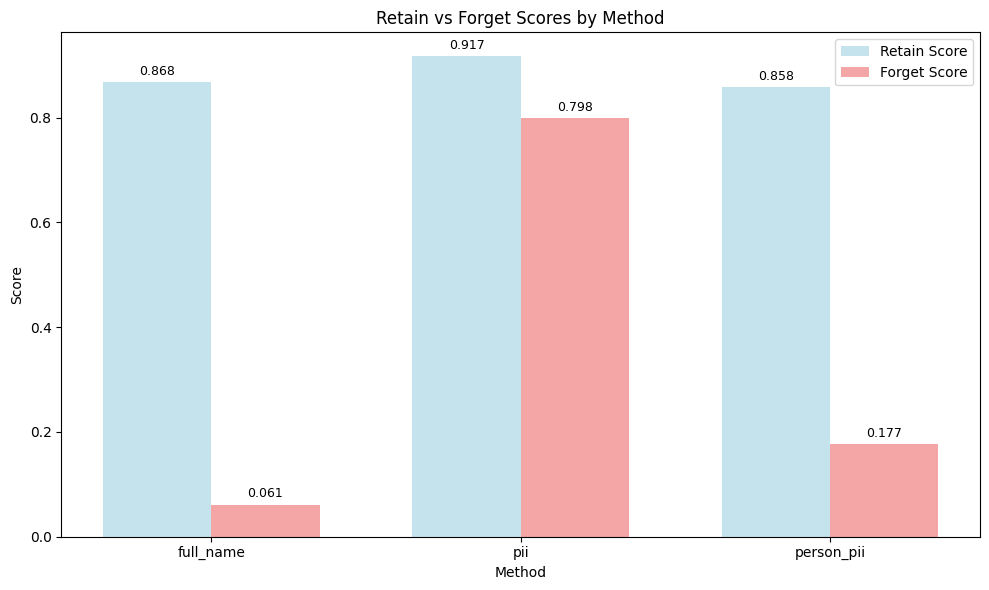


Summary:
Best Retain Score: pii (0.917)
Best Forget Score (lowest): full_name (0.061)


In [ ]:

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(df['method']))
width = 0.35

bars1 = ax.bar(x - width/2, df['agg_retain_score'], width, label='Retain Score', color='lightblue', alpha=0.7)
bars2 = ax.bar(x + width/2, df['agg_forget_score'], width, label='Forget Score', color='lightcoral', alpha=0.7)

ax.set_xlabel('Method')
ax.set_ylabel('Score')
ax.set_title('Retain vs Forget Scores by Method')
ax.set_xticks(x)
ax.set_xticklabels(df['method'])
ax.legend()

# Add value labels on bars
for bar in bars1:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

for bar in bars2:
    height = bar.get_height()
    ax.annotate(f'{height:.3f}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Print summary
print("\nSummary:")
print(f"Best Retain Score: {df.loc[df['agg_retain_score'].idxmax(), 'method']} ({df['agg_retain_score'].max():.3f})")
print(f"Best Forget Score (lowest): {df.loc[df['agg_forget_score'].idxmin(), 'method']} ({df['agg_forget_score'].min():.3f})")

We can clearly see that including pii separately results in very weak forgetting, and inlcuding both PII and Subject also results in weaker (but much better) unlearning


- It is surpising to me that including both subjects results in weaker unlearning than just full_name. This means that, whilst we add less noise to our exameples, we forget more. Of course, the relationship is not stupidly linear, as it is very important to realize the contrastive learning element of this. The idea of PerMU is to isolate the central fact of the sample, as the corrupted run results in a logit that are more grammar based rather than fact-related, and then subtracting corrupt_run_logits - clean_run_logits, thus subtracting the fact-related information, and giving room to tokens that are more based on grammar structure (in our case it will almost def halucinate other PII). However, when we add noise to both subject and PII, then the unlearning effect can become more washed out (not as strong for particular facts), and so the subtraction does not result in the same unlearning effect. We can probably confirm this by calculating the entropy of the last layer logits for the corrupt run, the person_pii subject key will almost definetely have less entropy.

- Interestingly, the retain score does not suffers least for the PII category, it must have something to do with there not being to much difference between the corrupt_logits and clean_logits when doing the contrastive bit, since the information of the PII is not the central/subject token of the method, the obvious one of course being the person itself. Similarly, the person is a stronger 'concept' than that number, since it has dozens of trianing samples with their names into it, so having entropy on the corrupt logits is definetely more guaranteed.


NOTE: I really want to do the entropy study, that would be so cool.


### Diference in time, subject/tokens processed between the 3 categories of Subject:


- full_name: 

        [2025-06-03 21:44:18,707][permu_stats][INFO] - PERFORMANCE STATISTICS
        [2025-06-03 21:44:18,707][permu_stats][INFO] - Runs: 1200
        [2025-06-03 21:44:18,708][permu_stats][INFO] - Avg time: 0.3396s (std: 0.1337)
        [2025-06-03 21:44:18,708][permu_stats][INFO] - Avg tokens: 7.19 (std: 2.84)
        [2025-06-03 21:44:18,709][permu_stats][INFO] - Avg subjects: 1.00 (std: 0.00)
        [2025-06-03 21:44:18,709][permu_stats][INFO] - Avg subject length: 6.50 (std: 1.53)
        [2025-06-03 21:44:18,709][permu_stats][INFO] - ==================================================


- pii: 

        [2025-06-03 22:54:24,803][permu_stats][INFO] - PERFORMANCE STATISTICS
        [2025-06-03 22:54:24,804][permu_stats][INFO] - Runs: 1200
        [2025-06-03 22:54:24,804][permu_stats][INFO] - Avg time: 2.1624s (std: 2.1039)
        [2025-06-03 22:54:24,805][permu_stats][INFO] - Avg tokens: 13.76 (std: 9.04)
        [2025-06-03 22:54:24,805][permu_stats][INFO] - Avg subjects: 1.38 (std: 0.60)
        [2025-06-03 22:54:24,806][permu_stats][INFO] - Avg subject length: 10.07 (std: 5.29)
        [2025-06-03 22:54:24,806][permu_stats][INFO] - ==================================================

- full_name + pii:

        [2025-06-04 00:16:25,977][permu_stats][INFO] - PERFORMANCE STATISTICS
        [2025-06-04 00:16:25,978][permu_stats][INFO] - Runs: 1200
        [2025-06-04 00:16:25,978][permu_stats][INFO] - Avg time: 2.4836s (std: 2.1293)
        [2025-06-04 00:16:25,979][permu_stats][INFO] - Avg tokens: 20.95 (std: 9.84)
        [2025-06-04 00:16:25,979][permu_stats][INFO] - Avg subjects: 2.38 (std: 0.60)
        [2025-06-04 00:16:25,980][permu_stats][INFO] - Avg subject length: 8.57 (std: 4.51)
        [2025-06-04 00:16:25,980][permu_stats][INFO] - ==================================================



As we can see, on avg creating a perturbed example is at least 7x faster, additionally it is also much more predictable. There are multiple reasons why that is the case:

1. Obviously, we simply have more subjects in the data for both the PII and the combined examples ( as we can have multiple PII per examples), more subjects -> more tokens to process -> more time
2. We can also see that the Avg to process is much higher, also with a much higher std for the PII examples. A lot of the PII have numbers in them, so tokenization would separate them and thus produce more tokens. Additionally, fact that some PII have numbers and others do not also explain the high std.

#### Updated : Comparing Subject Key settings

In [6]:
import pandas as pd
import json
import os

# Define subject keys and initialize data containers
subject_keys = ["subject","subjectembedding","subject_pii", "subject_person_pii"]
eval_data, raw_stats_data, summary_stats_data = [], [], []

# Process each subject key
for subject_key in subject_keys:
    template_path = f'/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama2-7b/forget10/_AllExperiments/CompareSubjectKeys/__PIIRankExperiment_llama2-7b_E8_B16_G2_SK{subject_key}'
    
    # Read eval.csv
    eval_path = f'{template_path}/eval_results/eval.csv'
    if os.path.exists(eval_path):
        eval_df = pd.read_csv(eval_path)
        eval_df['config'] = subject_key
        eval_data.append(eval_df)
    
    # Read raw stats JSON
    raw_path = f'{template_path}_ContrastLogTrue/permu_experiment_raw_data1.json'
    if os.path.exists(raw_path):
        with open(raw_path, 'r') as f:
            raw_data = json.load(f)
        raw_df = pd.json_normalize(raw_data) if isinstance(raw_data, dict) else pd.DataFrame(raw_data if isinstance(raw_data, list) else [raw_data])
        raw_df['config'] = subject_key
        raw_stats_data.append(raw_df)
    
    # Read summary stats JSON
    summary_path = f'{template_path}_ContrastLogTrue/permu_experiment_summary1.json'
    if os.path.exists(summary_path):
        with open(summary_path, 'r') as f:
            summary_data = json.load(f)
        summary_df = pd.json_normalize(summary_data) if isinstance(summary_data, dict) else pd.DataFrame(summary_data if isinstance(summary_data, list) else [summary_data])
        summary_df['config'] = subject_key
        summary_stats_data.append(summary_df)

# Create final dataframes
eval_df_final = pd.concat(eval_data, ignore_index=True) if eval_data else pd.DataFrame()
eval_df_final.loc[eval_df_final['config'] == 'subject', 'config'] = 'subject_person'
raw_stats_df_final_old = pd.concat(raw_stats_data, ignore_index=True) if raw_stats_data else pd.DataFrame()
summary_stats_df_final_old = pd.concat(summary_stats_data, ignore_index=True) if summary_stats_data else pd.DataFrame()

print(f"Created dataframes - Eval: {eval_df_final.shape}, Raw: {raw_stats_df_final.shape}, Summary: {summary_stats_df_final.shape}")

NameError: name 'raw_stats_df_final' is not defined

In [ ]:
raw_stats_df_final_old

,forget_loss,experiment_info.experiment_name,experiment_info.timestamp,experiment_info.total_batches,entropy.clean,entropy.corrupt,entropy.difference,entropy.contrasted,entropy.student,magnitude.clean,magnitude.corrupt,magnitude.difference,magnitude.contrasted,magnitude.student,kl_divergence.corrupt_vs_clean,config
0,"[2.2222671508789062, 2.2019801139831543, 2.546...",permu_experiment,20250610_181421,100,"[0.06423548609018326, 0.03975243493914604, 0.0...","[0.709168553352356, 0.5517546534538269, 0.8486...","[0.8442301750183105, 0.6538289189338684, 1.014...","[0.46138662099838257, 0.345060259103775, 0.473...","[0.06423548609018326, 0.03975243493914604, 0.0...","[27.995689392089844, 28.19724464416504, 27.930...","[23.131357192993164, 23.737817764282227, 22.10...","[20.943538665771484, 21.47516441345215, 20.043...","[23.305173873901367, 23.55010986328125, 23.147...","[27.995689392089844, 28.19724464416504, 27.930...","[4.620646953582764, 4.439059734344482, 5.69340...",subject
1,"[7.293713569641113, 6.697388172149658, 6.72405...",permu_experiment,20250610_184937,100,"[0.06423548609018326, 0.03975243493914604, 0.0...","[1.4518404006958008, 1.226744294166565, 1.5849...","[1.758205533027649, 1.5020631551742554, 1.9311...","[1.1489043235778809, 0.9427213668823242, 1.133...","[0.06423548609018326, 0.03975243493914604, 0.0...","[27.995689392089844, 28.19724464416504, 27.930...","[18.246551513671875, 19.034957885742188, 17.62...","[16.62486457824707, 17.296730041503906, 16.099...","[19.554258346557617, 19.9826602935791, 19.7526...","[27.995689392089844, 28.19724464416504, 27.930...","[8.930779457092285, 8.25547981262207, 9.270486...",subjectembedding
2,"[0.7599822878837585, 0.6922346353530884, 0.723...",permu_experiment,20250610_181935,100,"[0.06423548609018326, 0.03975243493914604, 0.0...","[0.6672035455703735, 0.8508142232894897, 0.659...","[0.7576649785041809, 0.9855489134788513, 0.777...","[0.17893332242965698, 0.15049098432064056, 0.2...","[0.06423548609018326, 0.03975243493914604, 0.0...","[27.995689392089844, 28.19724464416504, 27.930...","[23.645151138305664, 22.544174194335938, 23.88...","[21.6068115234375, 20.593477249145508, 21.7397...","[25.512798309326172, 25.812496185302734, 25.42...","[27.995689392089844, 28.19724464416504, 27.930...","[6.217160701751709, 7.076653480529785, 5.18094...",subject_pii
3,"[1.629743218421936, 1.4388542175292969, 1.8022...",permu_experiment,20250610_182440,100,"[0.06423548609018326, 0.03975243493914604, 0.0...","[1.247754693031311, 1.2092792987823486, 1.4398...","[1.4179376363754272, 1.3930885791778564, 1.640...","[0.31173932552337646, 0.23407959938049316, 0.3...","[0.06423548609018326, 0.03975243493914604, 0.0...","[27.995689392089844, 28.19724464416504, 27.930...","[19.94159507751465, 19.551799774169922, 19.198...","[18.414199829101562, 18.097461700439453, 17.71...","[25.083524703979492, 25.554922103881836, 24.82...","[27.995689392089844, 28.19724464416504, 27.930...","[10.014156341552734, 10.913442611694336, 10.11...",subject_person_pii


In [7]:
import pandas as pd
import json
import os

# Define subject keys and initialize data containers
#subject_keys = ["subject","subjectembedding","subject_pii", "subject_person_pii"]
configs = ['k1_match_first']
eval_data, raw_stats_data, summary_stats_data = [], [], []

# Process each subject key
for config in configs:
    template_path = f'/projects/0/hpmlprjs/LLM/danp/UGBench/experiment/PII/llama2-7b/forget10/_AllExperiments/Experiment_KDistance/KDistance_Experiment_llama2-7b_E8_B16_{config}_LogitLogging'
    
    # Read eval.csv
    eval_path = f'{template_path}/eval_results/eval.csv'
    if os.path.exists(eval_path):
        eval_df = pd.read_csv(eval_path)
        eval_df['config'] = config
        eval_data.append(eval_df)
    
    # Read raw stats JSON
    raw_path = f'{template_path}/permu_experiment_raw_data1.json'
    if os.path.exists(raw_path):
        with open(raw_path, 'r') as f:
            raw_data = json.load(f)
        raw_df = pd.json_normalize(raw_data) if isinstance(raw_data, dict) else pd.DataFrame(raw_data if isinstance(raw_data, list) else [raw_data])
        raw_df['config'] = config
        raw_stats_data.append(raw_df)
    
    # Read summary stats JSON
    summary_path = f'{template_path}/permu_experiment_summary1.json'
    if os.path.exists(summary_path):
        with open(summary_path, 'r') as f:
            summary_data = json.load(f)
        summary_df = pd.json_normalize(summary_data) if isinstance(summary_data, dict) else pd.DataFrame(summary_data if isinstance(summary_data, list) else [summary_data])
        summary_df['config'] = config
        summary_stats_data.append(summary_df)

# Create final dataframes
eval_df_final = pd.concat(eval_data, ignore_index=True) if eval_data else pd.DataFrame()
#eval_df_final.loc[eval_df_final['config'] == 'subject', 'config'] = 'subject_person'
raw_stats_df_final = pd.concat(raw_stats_data, ignore_index=True) if raw_stats_data else pd.DataFrame()
summary_stats_df_final = pd.concat(summary_stats_data, ignore_index=True) if summary_stats_data else pd.DataFrame()

print(f"Created dataframes - Eval: {eval_df_final.shape}, Raw: {raw_stats_df_final.shape}, Summary: {summary_stats_df_final.shape}")

Created dataframes - Eval: (0, 0), Raw: (1, 16), Summary: (1, 76)


In [8]:
summary_stats_df_final_old = summary_stats_df_final_old[summary_stats_df_final_old['config'] == 'subjectembedding']
summary_stats_df_final = pd.concat([summary_stats_df_final, summary_stats_df_final_old], ignore_index=True)

In [9]:
raw_stats_df_final_old = raw_stats_df_final_old[raw_stats_df_final_old['config'] == 'subjectembedding']
raw_stats_df_final = pd.concat([raw_stats_df_final, raw_stats_df_final_old], ignore_index=True)

In [10]:
raw_stats_df_final

,forget_loss,experiment_info.experiment_name,experiment_info.timestamp,experiment_info.total_batches,entropy.clean,entropy.corrupt,entropy.difference,entropy.contrasted,entropy.student,magnitude.clean,magnitude.corrupt,magnitude.difference,magnitude.contrasted,magnitude.student,kl_divergence.corrupt_vs_clean,config
0,"[2.5149927139282227, 2.179631233215332, 2.4726...",permu_experiment,20250611_230557,100,"[0.06423548609018326, 0.03975243493914604, 0.0...","[0.7528139352798462, 0.5855322480201721, 0.905...","[0.8847053050994873, 0.7253125905990601, 1.070...","[0.4240633249282837, 0.40126264095306396, 0.56...","[0.06423548609018326, 0.03975243493914604, 0.0...","[27.995689392089844, 28.19724464416504, 27.930...","[22.86023712158203, 23.396926879882812, 21.982...","[20.7038631439209, 21.135923385620117, 19.9420...","[23.213172912597656, 23.27950096130371, 23.040...","[27.995689392089844, 28.19724464416504, 27.930...","[4.844326496124268, 4.3284220695495605, 5.7505...",k1_match_first
1,"[7.293713569641113, 6.697388172149658, 6.72405...",permu_experiment,20250610_184937,100,"[0.06423548609018326, 0.03975243493914604, 0.0...","[1.4518404006958008, 1.226744294166565, 1.5849...","[1.758205533027649, 1.5020631551742554, 1.9311...","[1.1489043235778809, 0.9427213668823242, 1.133...","[0.06423548609018326, 0.03975243493914604, 0.0...","[27.995689392089844, 28.19724464416504, 27.930...","[18.246551513671875, 19.034957885742188, 17.62...","[16.62486457824707, 17.296730041503906, 16.099...","[19.554258346557617, 19.9826602935791, 19.7526...","[27.995689392089844, 28.19724464416504, 27.930...","[8.930779457092285, 8.25547981262207, 9.270486...",subjectembedding


In [11]:
# Alternative version with horizontal bar plots for better label readability

import matplotlib.pyplot as plt
import seaborn as sns

def plot_retain_forget_scores_horizontal(df, retain_col, forget_col, cat_col="method", title_prefix="Exact", figsize=(14, 10), adaptive_range=False,retain_title=None,forget_title=None):
    """
    Plot retain and forget scores using horizontal bar plots for better label readability.
    """
    
    # Create figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=figsize)
    
    # Reset index to make config a column if it's currently the index
    plot_df = df[[retain_col, forget_col, cat_col]].reset_index()
    
    # Sort data for retain scores (increasing order)
    retain_order = plot_df.sort_values(retain_col)[cat_col].tolist()
    
    # Sort data for forget scores (decreasing order)
    forget_order = plot_df.sort_values(forget_col, ascending=False)[cat_col].tolist()
    
    # Plot 1: Retain Scores (Blue) - Horizontal bars
    sns.barplot(data=plot_df, y=cat_col, x=retain_col, ax=ax1, color='steelblue', order=retain_order)
    if retain_title is not None:
        ax1.set_title(retain_title, fontsize=14, pad=20)
    else:
        ax1.set_title(f'{title_prefix} Retain Scores by {cat_col.capitalize()}', fontsize=14, pad=20)
    ax1.set_ylabel(cat_col.capitalize(), fontsize=12)
    ax1.set_xlabel(f'{title_prefix} Retain Score', fontsize=12)
    
    # Add score labels at the end of retain bars
    for i, category in enumerate(retain_order):
        value = plot_df[plot_df[cat_col] == category][retain_col].iloc[0]
        # Smart formatting: show up to 4 decimals only if needed to avoid showing 0
        if value == 0:
            formatted_value = ' '
        elif f'{value:.2f}'.rstrip('0').rstrip('.') == '0':
            # If 2 decimals would show as 0, use up to 4 decimals
            formatted_value = f'{value:.4f}'.rstrip('0').rstrip('.')
        else:
            # Otherwise use up to 2 decimals
            formatted_value = f'{value:.2f}'.rstrip('0').rstrip('.')
        ax1.text(value + 0.01, i, formatted_value, 
                va='center', ha='left', fontsize=10, fontweight='bold')
    
    # Plot 2: Forget Scores (Red) - Horizontal bars
    sns.barplot(data=plot_df, y=cat_col, x=forget_col, ax=ax2, color='crimson', order=forget_order)
    if forget_title is not None:
        ax2.set_title(forget_title, fontsize=14, pad=20)
    else:
        ax2.set_title(f'{title_prefix} Forget Scores by {cat_col.capitalize()}', fontsize=14, pad=20)
    ax2.set_ylabel(cat_col.capitalize(), fontsize=12)
    ax2.set_xlabel(f'{title_prefix} Forget Score', fontsize=12)
    
    # Add score labels at the end of forget bars
    for i, category in enumerate(forget_order):
        value = plot_df[plot_df[cat_col] == category][forget_col].iloc[0]
        # Smart formatting: show up to 4 decimals only if needed to avoid showing 0
        if value == 0:
            formatted_value = ' '
        elif f'{value:.2f}'.rstrip('0').rstrip('.') == '0':
            # If 2 decimals would show as 0, use up to 4 decimals
            formatted_value = f'{value:.4f}'.rstrip('0').rstrip('.')
        else:
            # Otherwise use up to 2 decimals
            formatted_value = f'{value:.2f}'.rstrip('0').rstrip('.')
        ax2.text(value + 0.01, i, formatted_value, 
                va='center', ha='left', fontsize=10, fontweight='bold')
    
    # Adapt x-axis ranges if requested
    if adaptive_range:
        # For retain scores
        retain_min, retain_max = plot_df[retain_col].min(), plot_df[retain_col].max()
        retain_padding = (retain_max - retain_min) * 0.1
        x_min_retain = max(0, retain_min - retain_padding)
        ax1.set_xlim(x_min_retain, retain_max + retain_padding)
        
        # For forget scores
        forget_min, forget_max = plot_df[forget_col].min(), plot_df[forget_col].max()
        forget_padding = (forget_max - forget_min) * 0.1
        x_min_forget = max(0, forget_min - forget_padding)
        ax2.set_xlim(x_min_forget, forget_max + forget_padding)
    
    plt.tight_layout(pad=3.0)
    plt.show()

KeyError: "None of [Index(['exact_retain_score', 'exact_forget_score', 'config'], dtype='object')] are in the [columns]"

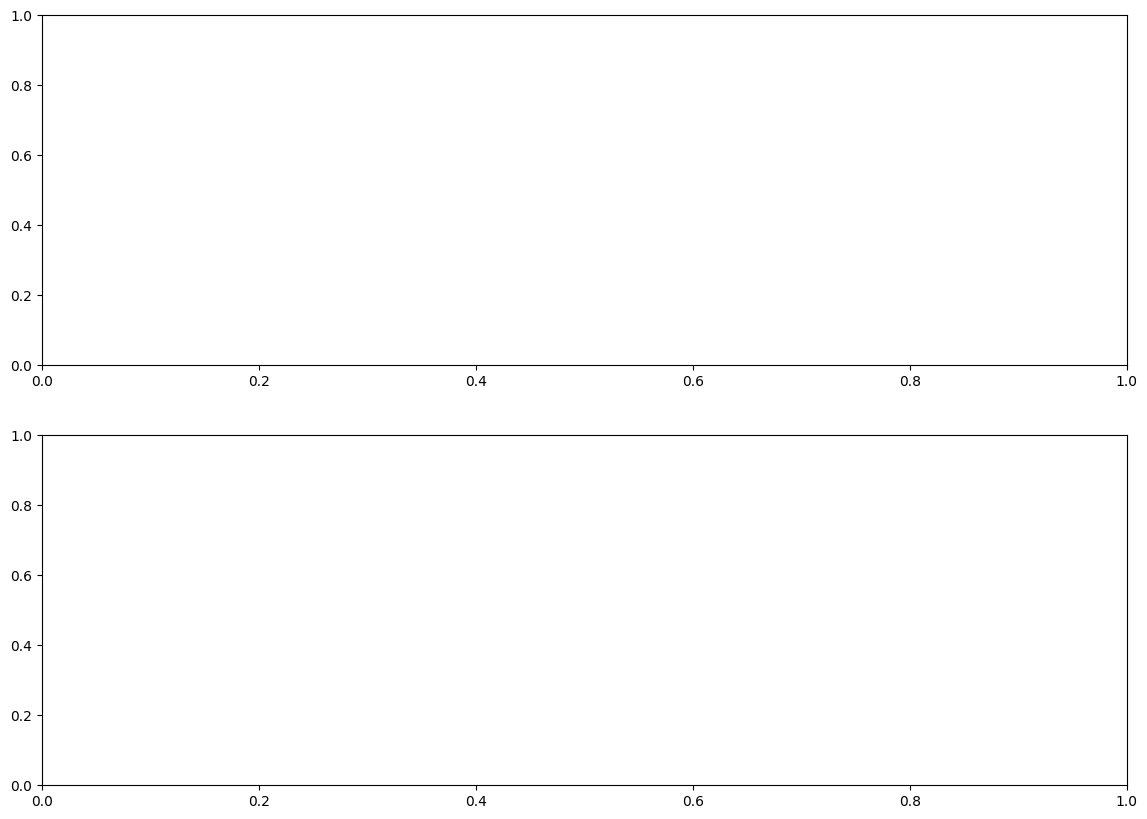

In [12]:
plot_retain_forget_scores_horizontal(eval_df_final, 'exact_retain_score', 'exact_forget_score', title_prefix='Exact',cat_col='config')


##### The 'person' key has by far the best results when it comes to the forget score, and slightly worse results w.r.t the retain score. It is the clear winner.


However, it is interesting and important to explore why that is. We can see the inherent forget/retain tradeoff in these 3 configuration settings as well, with order of best forget and best retain being completely flipped.

On first thought, it is interesting that the setting with the highest noise addition / subject corruption has the best Retain scores. However, given that we are using contrasted learning, the corrupted logits are only part of the puzzle, they are supposed to be the logits in which subject-related facts are removed (like soccer from Messi), then we need to subtract the clean logits (which do contain the facts) for even further subject removal. However, here it seems like adding to much noise to the answer might reduce the entire corrupt distribution, and possibly after some grad updates the clean distribution as well.


We can analyze of the corrupt logits, the unlearning signal and the diveregence of corrupt and clean across our 3 configs.

In [ ]:
# Reorder columns with 'config' first
cols = summary_stats_df_final.columns.tolist()
cols.insert(0, cols.pop(cols.index('config')))
summary_stats_df_final = summary_stats_df_final[cols]

In [ ]:
summary_stats_df_final[['config','entropy_stats.clean.median','entropy_stats.corrupt.median','kl_divergence_stats.corrupt_vs_clean.median']]

,config,entropy_stats.clean.median,entropy_stats.corrupt.median,kl_divergence_stats.corrupt_vs_clean.median
0,subject,2.010990,2.786260,1.654959
1,subject_pii,0.724530,1.798596,3.102132
2,subject_person_pii,1.387625,3.469290,4.648612


In [ ]:
def print_grouped_stats(df):
    configs = df['config'].unique()
    
    # Group columns by type
    entropy_cols = [col for col in df.columns if 'entropy_stats' in col]
    magnitude_cols = [col for col in df.columns if 'magnitude_stats' in col]
    kl_cols = [col for col in df.columns if 'kl_divergence' in col]
    experiment_cols = [col for col in df.columns if 'experiment_info' in col]
    
    print("EXPERIMENT INFO")
    print("=" * 60)
    print(df[['config'] + experiment_cols].to_string(index=False))
    print("\n")
    
    print("ENTROPY STATISTICS")
    print("=" * 60)
    print(df[['config'] + entropy_cols].round(4).to_string(index=False))
    print("\n")
    
    print("MAGNITUDE STATISTICS")
    print("=" * 60)
    print(df[['config'] + magnitude_cols].round(4).to_string(index=False))
    print("\n")
    
    print("KL DIVERGENCE STATISTICS")
    print("=" * 60)
    print(df[['config'] + kl_cols].round(4).to_string(index=False))

print_grouped_stats(summary_stats_df_final)

EXPERIMENT INFO
            config experiment_info.experiment_name experiment_info.timestamp  experiment_info.total_batches
           subject                permu_experiment           20250610_181421                            100
       subject_pii                permu_experiment           20250610_181935                            100
subject_person_pii                permu_experiment           20250610_182440                            100


ENTROPY STATISTICS
            config  entropy_stats.clean.mean  entropy_stats.clean.std  entropy_stats.clean.min  entropy_stats.clean.max  entropy_stats.clean.median  entropy_stats.clean.count  entropy_stats.corrupt.mean  entropy_stats.corrupt.std  entropy_stats.corrupt.min  entropy_stats.corrupt.max  entropy_stats.corrupt.median  entropy_stats.corrupt.count  entropy_stats.difference.mean  entropy_stats.difference.std  entropy_stats.difference.min  entropy_stats.difference.max  entropy_stats.difference.median  entropy_stats.difference.count  e

From the following data, the most telling two datapoints are the mean_kl_divergence and the contrasted_logits_entropy.

1. Mean KL_Divergence

- subject: 2.29 (lowest)
- subject_pii: 3.55 (moderate)
- subject_person_pii: 5.60 (highest)


PerMU relies on the subtraction : "p(Yt|y<t) = p(y|x') - C·p(y|x)" for its contrstive learning. When the KL diveregence is too high, it indicates that our two distributions are drastically different, potentially making the subtracted target distribution too unstable and difficult. So when I do contrasted learning the original distribution is too different.



2. Contrasted Entropy:

This is the entropy score for the contrasted logits ( i.e the result of the subtraction mentioned above). This result is how the loss is calculated (with a student-teacher architecture wrt original logits). 


subject: 2.41 (highest) - maintains good diversity
subject_pii: 1.32 (lowest) - too concentrated/collapsed -> By the gets more and more entropic.
subject_person_pii: 1.65 (moderate) - but with high instability


The entropy for the later two is quite low, meaning they do not maintain good diversity. Given that the entire idea of the contrasted logits is to remove fact-related information and simply rely on general structure, that means having quite good diversity (which our subject key has) on the contrasted logits is important, this is not the case here. You can see that subject_pii actuallly has the lowest value, but we need to keep in mind the values of Mean KL_Divergence.





Basically, having the highest difference does not necessarily mean the best unlearning signal, in this case the lowest difference actually does that. The KL_diveregnece


#### Plot the Raw Data

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_training_metrics(df, metric_column, figsize=(12, 8)):
    """
    Plot training metrics across batches for different configs
    
    Args:
        df: DataFrame with configs and metric columns containing arrays of 100 values
        metric_column: Column name to plot (e.g., 'entropy.clean')
        figsize: Figure size tuple
    """
    plt.figure(figsize=figsize)
    
    # Colors for different configs
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
    
    for idx, (_, row) in enumerate(df.iterrows()):
        config_name = row['config']
        metric_values = row[metric_column]
        
        # Handle different data types
        if isinstance(metric_values, str):
            # If stored as string, try to convert
            try:
                metric_values = eval(metric_values)  # or use ast.literal_eval for safety
            except:
                print(f"Could not parse values for {config_name}")
                continue
        
        # Create x-axis (batch numbers 0-99)
        x_values = list(range(len(metric_values)))
        
        # Plot the line
        plt.plot(x_values, metric_values, 
                label=f'{config_name}', 
                color=colors[idx % len(colors)], 
                linewidth=2, 
                alpha=0.8)
    
    plt.xlabel('Batch Number', fontsize=12)
    plt.ylabel(metric_column, fontsize=12)
    plt.title(f'{metric_column} Across Training Batches', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    return plt


In [42]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def plot_training_metrics_academic(df, metric_columns, figsize=(15, 10)):
    """
    Plot training metrics across batches for different configs in academic style
    
    Args:
        df: DataFrame with configs and metric columns containing arrays of 100 values
        metric_columns: List of column names to plot (e.g., ['forget_loss', 'entropy.corrupt'])
        figsize: Figure size tuple
    """
    # Set up the figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=figsize, sharex=True)
    
    # Academic color palette - neutral and professional
    colors = ['#2C3E50', '#8E44AD', '#16A085', '#E67E22', '#34495E']
    
    # Enhanced font settings for academic appearance
    plt.rcParams.update({
        'font.size': 12,
        'font.family': 'serif',
        'axes.linewidth': 1.2,
        'grid.linewidth': 0.8,
        'lines.linewidth': 2.5
    })
    
    # Define proper academic titles and labels
    titles = {
        'forget_loss': 'Forget Loss During Training',
        'entropy.corrupt': 'Entropy of Corrupted Logits During Training',
    }
    
    ylabels = {
        'forget_loss': 'Forget Loss',
        'entropy.corrupt': 'Entropy Corruption'
    }
    
    for plot_idx, metric_column in enumerate(metric_columns):
        ax = axes[plot_idx]
        
        for idx, (_, row) in enumerate(df.iterrows()):
            config_name = row['config']
            metric_values = row[metric_column]
            
            # Handle different data types
            if isinstance(metric_values, str):
                try:
                    metric_values = eval(metric_values)  # or use ast.literal_eval for safety
                except:
                    print(f"Could not parse values for {config_name}")
                    continue
            
            # Create x-axis (batch numbers 0-99)
            x_values = list(range(len(metric_values)))
            
            # Plot the line with enhanced styling
            ax.plot(x_values, metric_values,
                   label=f'{config_name}',
                   color=colors[idx % len(colors)],
                   linewidth=2.5,
                   alpha=0.9)
        
        # Enhanced styling for academic appearance
        ax.set_ylabel(ylabels.get(metric_column, metric_column), 
                     fontsize=14, fontweight='bold')
        ax.set_title(titles.get(metric_column, f'{metric_column} Across Training Batches'), 
                    fontsize=16, fontweight='bold', pad=20)
        
        # Enhanced grid and legend
        ax.grid(True, alpha=0.4, linestyle='-', linewidth=0.8)
        ax.legend(fontsize=12, frameon=True, fancybox=True, shadow=True, 
                 loc='best', framealpha=0.9)
        
        # Improve tick labels
        ax.tick_params(axis='both', which='major', labelsize=11, width=1.2)
        
        # Add subtle background color
        ax.set_facecolor('#fafafa')
        
        # Enhance spines
        for spine in ax.spines.values():
            spine.set_linewidth(1.2)
            spine.set_color('#333333')
    
    # Set common x-label only on bottom plot
    axes[-1].set_xlabel('Training Batch Number', fontsize=14, fontweight='bold')
    
    # Add overall title
   #fig.suptitle('Training Dynamics: Loss and Entropy Metrics Comparison', 
   #             fontsize=18, fontweight='bold', y=0.98)
    
    # Adjust layout for better spacing
    plt.tight_layout()
    plt.subplots_adjust(top=0.93, hspace=0.3)
    
    return fig

# Alternative single-plot version for individual metrics
def plot_single_metric_academic(df, metric_column, figsize=(12, 8)):
    """
    Plot a single training metric with academic styling
    """
    plt.figure(figsize=figsize)
    
    # Academic styling
    plt.rcParams.update({
        'font.size': 12,
        'font.family': 'serif',
        'axes.linewidth': 1.2,
        'grid.linewidth': 0.8,
        'lines.linewidth': 2.5
    })
    
    colors = ['#2C3E50', '#8E44AD', '#16A085', '#E67E22', '#34495E']
    
    for idx, (_, row) in enumerate(df.iterrows()):
        config_name = row['config']
        metric_values = row[metric_column]
        
        if isinstance(metric_values, str):
            try:
                metric_values = eval(metric_values)
            except:
                print(f"Could not parse values for {config_name}")
                continue
        
        x_values = list(range(len(metric_values)))
        
        plt.plot(x_values, metric_values,
                label=f'{config_name}',
                color=colors[idx % len(colors)],
                linewidth=2.5,
                alpha=0.9)
    
    plt.xlabel('Training Batch Number', fontsize=14, fontweight='bold')
    plt.ylabel(metric_column.replace('_', ' ').replace('.', ' ').title(), 
              fontsize=14, fontweight='bold')
    plt.title(f'{metric_column.replace("_", " ").replace(".", " ").title()} During Training', 
              fontsize=16, fontweight='bold', pad=20)
    
    plt.legend(fontsize=12, frameon=True, fancybox=True, shadow=True, 
              loc='best', framealpha=0.9)
    plt.grid(True, alpha=0.4, linestyle='-', linewidth=0.8)
    
    # Enhanced styling
    ax = plt.gca()
    ax.set_facecolor('#fafafa')
    ax.tick_params(axis='both', which='major', labelsize=11, width=1.2)
    
    for spine in ax.spines.values():
        spine.set_linewidth(1.2)
        spine.set_color('#333333')
    
    plt.tight_layout()
    return plt

# Usage examples:
"""
# For multi-plot (recommended for your case)
fig = plot_training_metrics_academic(df, ['forget_loss', 'entropy.corrupt'])
plt.show()

# For single plots
plot_single_metric_academic(df, 'forget_loss')
plt.show()

plot_single_metric_academic(df, 'entropy.corrupt')
plt.show()
"""

"\n# For multi-plot (recommended for your case)\nfig = plot_training_metrics_academic(df, ['forget_loss', 'entropy.corrupt'])\nplt.show()\n\n# For single plots\nplot_single_metric_academic(df, 'forget_loss')\nplt.show()\n\nplot_single_metric_academic(df, 'entropy.corrupt')\nplt.show()\n"

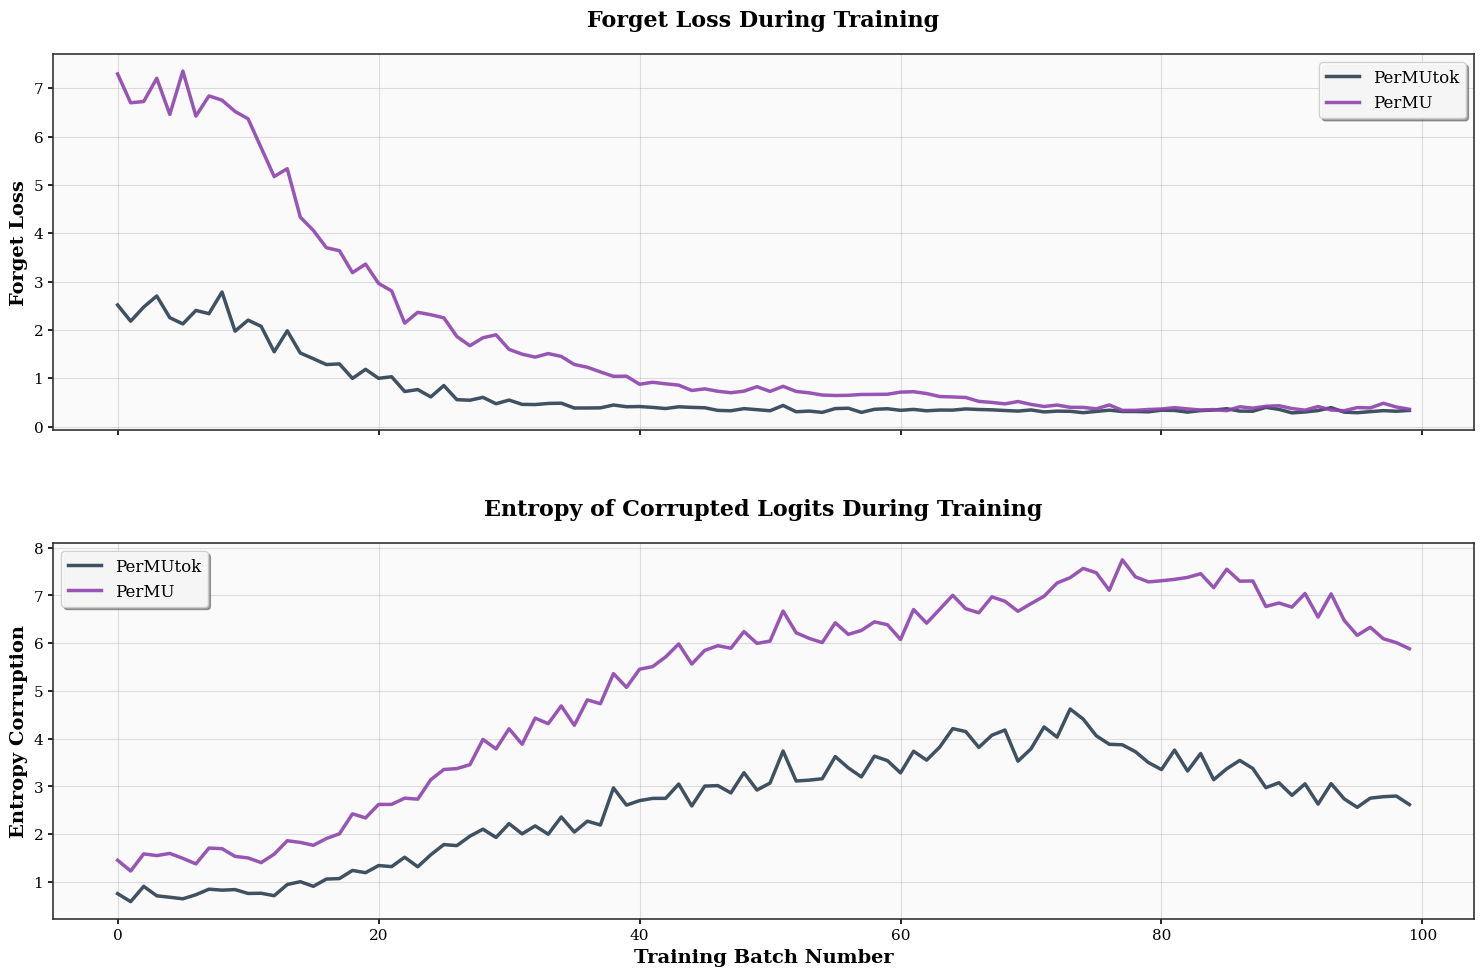

In [43]:
fig = plot_training_metrics_academic(raw_stats_df_final, ['forget_loss', 'entropy.corrupt'])

In [32]:
raw_stats_df_final['config'] = raw_stats_df_final['config'].replace({
    'TLPerMU': 'PerMUtok',
    'subjectembedding': 'PerMU',
})

In [25]:
raw_stats_df_final.columns

Index(['forget_loss', 'experiment_info.experiment_name',
       'experiment_info.timestamp', 'experiment_info.total_batches',
       'entropy.clean', 'entropy.corrupt', 'entropy.difference',
       'entropy.contrasted', 'entropy.student', 'magnitude.clean',
       'magnitude.corrupt', 'magnitude.difference', 'magnitude.contrasted',
       'magnitude.student', 'kl_divergence.corrupt_vs_clean', 'config'],
      dtype='object')

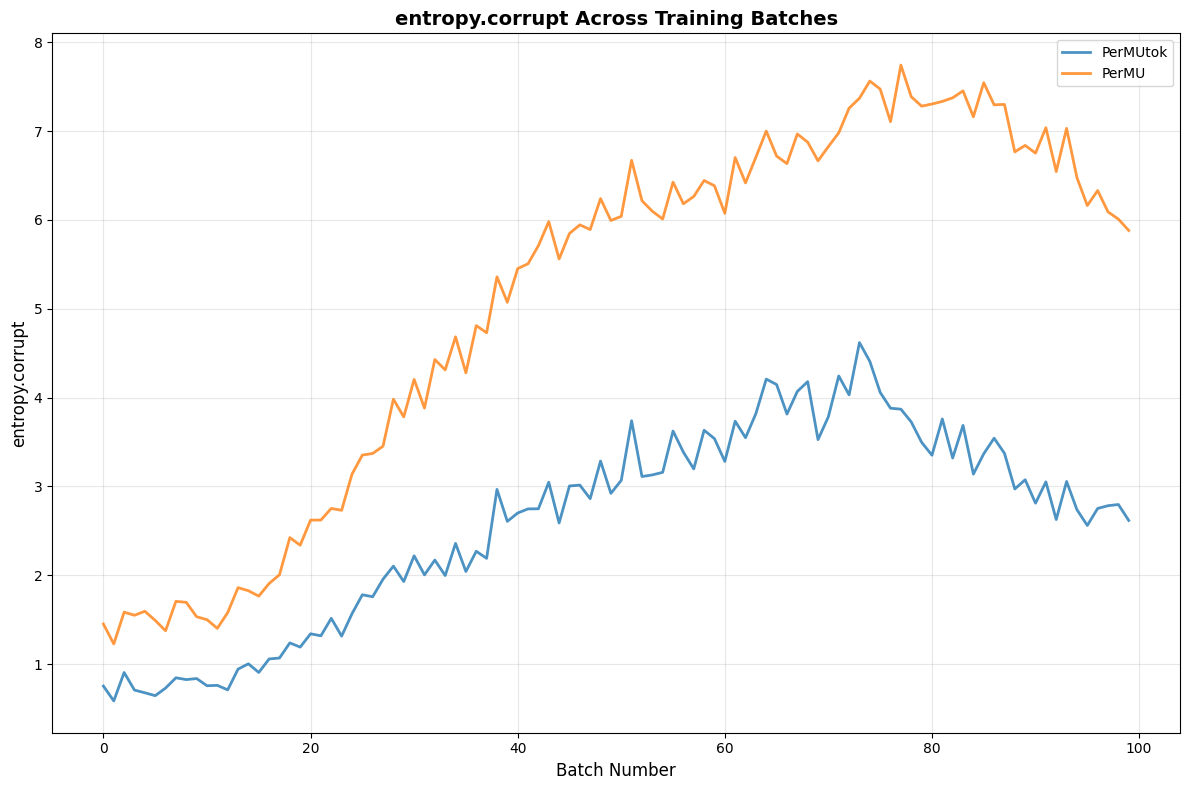

In [33]:
# Usage examples:
# Plot entropy.clean
plot_training_metrics(raw_stats_df_final, 'entropy.corrupt')
plt.show()

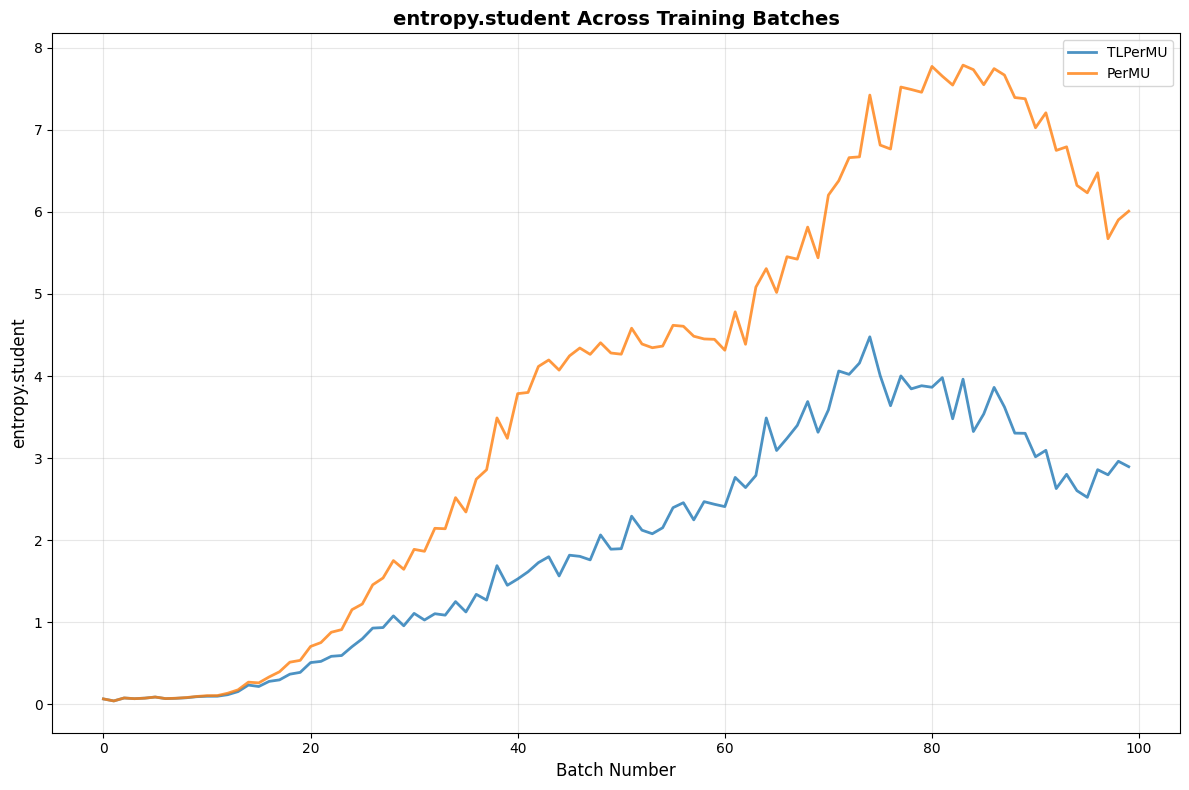

In [20]:
# Usage examples:
# Plot entropy.clean
plot_training_metrics(raw_stats_df_final, 'entropy.student')
plt.show()

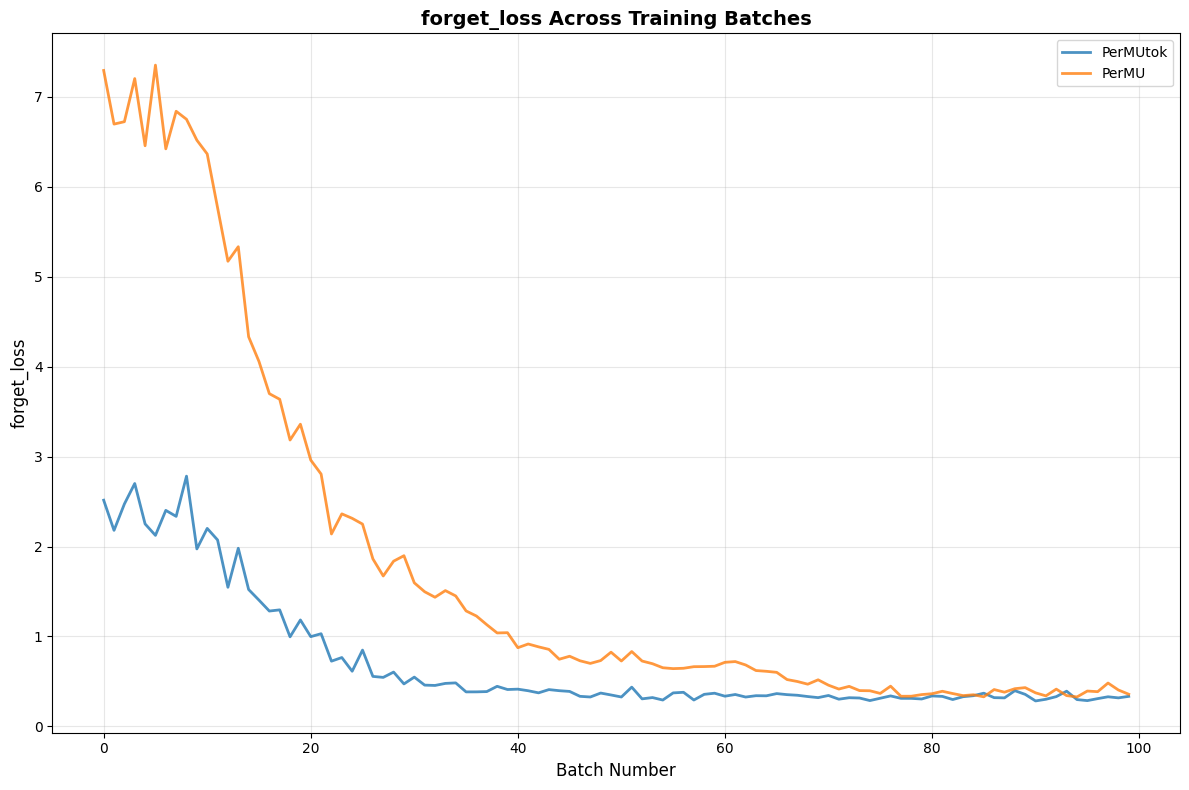

In [34]:

# Usage examples:
# Plot entropy.clean
plot_training_metrics(raw_stats_df_final, 'forget_loss')
plt.show()

In [15]:

# Usage examples:
plot_training_metrics(raw_stats_df_final, 'kl_divergence.corrupt_vs_clean')
plt.show()

NameError: name 'plot_training_metrics' is not defined

#### Replace Prob Explanation


PerMU is primarily based on the idea of subtrcating factually-unrealted probability (corrupt logits) from factually related prability distriubtion (clean logits), and thus further removing the factual influence. If we do not pertrub the corrupt logits enough, then they become way too similar to the clean logits, and then the unlearning signal is much weaker, thus having lower replace_prob means less unlearning. It also does not help that some subjects are made up of very few tokens so they might be very little perturbed.



#### K Distance Explanation


This one is not as easy or intuitive, especially because the results are quite similar. It was clearly visible though that the k1_first_char setting was better at unlearning more difficult examples. Our plots here don't seem to help us out with this, since the behaviour is not too different. We see slightly higher KLdivergence in the beginning which makes sense, then it equals out, also the student entropy is higher in the beginning, and then it also more or less equals out. Not sure, if this makes sense, but my initial idea is that adding too much noise to the subject would corrupt the sample in a way where the contrasted logits are not pointing in the direction of forgetting sugbject-related facts, but more so forgetting more sample specifc facts (better at forgetting the DirectQA), perhaps since the contrasted_logits are too big, so the trainign is steered in a more naive direction, rather than slowly removing the influence of the concept.